# Descrizione del problema
Il problema riguarda lo **scheduling**. Sono dati $G$ ingegneri che lavorono per $L$ giorni. La realtà è composta da 3 elementi:
* **Features**: sono le funzionalità implementate nei prodotti;
* **Services**: sono i programmi che sono in esecuzione sui server;
* **Binaries**: modellano un server. Ogni *binary* può avere in esecuzione più servizi;

Una **Feature** è contraddistinta dal numero di utenti che riesce a soddisfare e da un insieme di servizi in cui deve essere implementata. Una **Feature** è disponibile ai clienti quando viene implementata in ogni servizio da cui dipende.
Un **Service** è presente su **uno e un solo binary**, ma su ogni **binary** è possibile inserire più **Services**.


In [1]:
from dataclasses import dataclass
from typing import List, Dict, Tuple, Set

@dataclass
class Binary:
    id: int
    services: List[int]
    working_on: int
    last_move: int
    last_work: int

    # se bisogna spostare un servizio da/verso il binary, nessuno deve essere a lavoro
    def can_move(self, day: int) -> bool:
        return max(self.last_move, self.last_work) <= day

    # si può lavorare su un binary solo se non è in corso una migrazione
    def can_work(self, day: int) -> bool:
        return self.last_move <= day


@dataclass
class Service:
    id: int
    name: str
    binary: int
    impl_features: List[str]


@dataclass
class Feature:
    idx: int
    name: str
    difficulty: int
    users: int
    dep_services: List[List]
    day_completed: int
    binaries: Set[int]
    
    # ritorna False appena trova un servizio non implementato, altrimenti True
    def is_finished(self) -> bool:
        for (service, completed) in self.dep_services:
            if not completed:
                return False
        return True


Ogni ingegnere è dotato di un array di operazioni da effettuare che tenere traccia delle sue attività. In particolare, la classe `Engineer` espone il metodo `add_op` che aggiunge l'operazione per un determinato giorno se e solo se è libero (grazie alla proprietà `avail`), altrimenti viene inserita un'operazione di `wait` della durata necessaria.

In [2]:
@dataclass
class Engineer:
    id: int
    avail: int
    ops: List[Tuple[str, List[int]]]

    def add_op(self, op_name: str, day: int, duration: int, values: List[int]):
        assert(self.avail <= day)
        if self.avail < day:
            self.ops.append(("wait", [day - self.avail]))

        self.ops.append((op_name, values))
        self.avail = day + duration
        

### Lettura input
Come prima cosa vengono letti i dati input e si effettua il parsing della prima riga per avere la dimensione del problema.

Successivamente vengono popolate le liste e il dizionario `service_to_id` per avere una corrispondenza tra nome e id del servizio.

* Lista dei binary: tutti i binary del sistema; per ogni binary si tiene traccia della list dei service installati e del numero di ingegneri che lavora al momento;
* Lista dei service; tutti i service del sistema. Per ogni service si tiene conto delle feature implementate al momento;
* Lista delle feature: tutte le feature del sistema. Ogni feature contiene una lista coppie (stringhe, booleani) in cui si tiene conto dei servizi da implementare e del loro stato (implementato si/no);

In [3]:
# lettura dei dati dal file di input
fname = "data/e.in"

with open(fname, "r") as f:
        lines = f.readlines()
        
# parsing della prima riga: dimensione del problema
L, G, S, B, F, N = [int(k) for k in lines[0].strip().split(" ")]

# creazione lista degli ingegneri
engineers: List[Engineer] = []
for i in range(G):
    engineers.append(Engineer(i, 0, []))
    
# creazione lista dei binaries
binaries: List[Binary] = []
for i in range(B):
    binaries.append(Binary(i, [], 0, 0, 0))

# creazione service e binary
services: List[Service] = []
service_to_id: Dict[str, int] = {}
for i, (service, binary) in enumerate([line.strip().split() for line in lines[1:S+1]]):
    bid = int(binary)
    b = binaries[bid]
    b.services.append(i)

    s = Service(i, service, bid, [])
    service_to_id[service] = i
    services.append(s)
        
# creazione features
features: List[Feature]= []
for i in range(F):
    features.append(Feature(i, "", 0, 0, [], 0, set()))

n = 0
for i, feature in enumerate(lines[1+S:]):
    # leggo solo le righe pari
    if i % 2 ==0:
        feature, num_services, difficulty, users = feature.strip().split(" ")
        s = [[service_to_id[s], False] for s in lines[1+S+1+i].split()]
        f = features[n]
        f.name, f.difficulty, f.users, f.dep_services = feature, int(difficulty), int(users), s
        n += 1

Attraverso la variabile `daily_schedule`, si tiene conto dell'implementazione degli ingegneri sui binaries esistenti. In particolare, questa variabile è modellata come una lista di tuple il cui secondo elemento indica quale binary $B_k$ con $b \in 0 \leq k < B$; mentre il primo il giorno $L_i$ con $i \in 0 \leq i < L$. Ad ogni iterazione (che corrisponde ad un avanzamento giornaliero) dell'algoritmo saranno eliminati dalla coda le attività svolte aggiornando il numero di ingegneri in lavorazione sul binary in questione, come mostrato nella procedura `process_timeline`. 

In [4]:
daily_schedule: List[Tuple[int, int]] = []

def process_timeline(day: int):
    while len(daily_schedule) > 0 and daily_schedule[0][0] <= day:
        bid: int = daily_schedule[0][1]
        binaries[bid].working_on -=1
        assert(binaries[bid].working_on >= 0)
        daily_schedule.pop(0)

## Attività
Di seguito sono illustrate le mosse che un ingegnere può effettuare.

Ciascuna mossa è caratterizzata da una durata. Per ogni mossa è definita una procedura per eseguirla sui dati di input. Ogni procedura ha la seguente firma:
* input:
    * ingegnere su cui schedulare l'attività;
    * giorno in cui effettuare l'attività;
    * feature, binary, service su cui effettuare l'attività;
* output:
    * durata dell'attività;

### Implementazione di una nuova feature
Su un *binary* $B_j$ può un ingegnere implementare tutti i servizi per una feature $F_i$. Questa mossa ha una durata $D_{Fi} + R_{Bj} + C_{Bj}$. Dove $D_{Fi}$ è data dalla complessità della **Feature**, $R_{Bj}$ è dato dal numero di servizi totali presenti nel *binary*, $C_{Bj}$ ingegneri che stanno già lavorando su $B_j$ nel giorno in cui viene *schedulata* l'attività. Inoltre, ogni ingegnere può implementare la stessa **Feature** su **binary** diversi. Infine, se più ingegneri sono *schedulati* per lavorare sullo stesso **binary** il primo della soluzione viene schedulato e conta per gli altri nel fattore $C_{Bj}$. L'esecuzione di questa funzione comporta l'aggiunta dell'operazione nella lista `daily_schedule`.

Questa funzione, nel caso in cui la feature risulti terminata, incrementa la variabile globale `score` che tiene traccia del punteggio ottenuto.

In [5]:
def implement_feature(e: int, day: int, f: int, b: int) -> int:
    # verifico la correttezza dell'input
    assert(b >= 0 and b < B)
    assert(day >=0 and day < L)
    assert(f >= 0 and f < F)
    assert(e >= 0 and e < G)
    global score
    # controllo eventuali lavori finiti
    process_timeline(day)
    
    feature = features[f]
    was_finished = feature.is_finished()

    # controllo che il binary non sia bloccato
    assert(binaries[b].last_move <= day)

    # calcolo della durata in accordo con la specifica
    duration  = feature.difficulty + len(binaries[b].services) + binaries[b].working_on

    # imposto come implementati tutti i servizi della feature f nel binary b
    for i, (service, done) in enumerate(feature.dep_services):
        if services[service].binary == b and not done:
            feature.dep_services[i][1] = True
            feature.day_completed = max(day + duration, feature.day_completed)
            services[service].impl_features.append(f)
    
    # se la feature è finita e non era terminata incremento il punteggio
    if feature.is_finished() and not was_finished:
        print("done feature", f)
        score += feature.users * max(0, L-feature.day_completed) 

    # aggiungo l'operazione all'ingegnere, aggiungo alla tabella di scheduling e incremento il numero di persone al lavoro
    engineers[e].add_op("impl", day, duration, [f, b])
    daily_schedule.append((day + duration, b))
    binaries[b].working_on+=1
    
    # print("debug:", "impl",e, day, f, b)
    return duration

### Migrazione di un service
Un ingegnere può spostare un servizio $S_i$ da un *binary* $B_j$ a $B_k$, mantenendo le funzionalità implementate. Per fare questa mossa, un ingegnere impiega $\max (R_{bj}, R_{bk})$ giorni dove $R_{bj}, R_{bk}$ sono i servizi in esecuzione rispettivamente su $B_j$ a $B_k$. Quest'azione però è bloccante: nessun ingegnere può lavorare su $B_j$ e $B_k$ quando è in corso una migrazione; 

In [6]:
def move_service(e: int, day: int, s: int, dst: int) -> None:
    # verifico la correttezza dell'input
    assert(s >= 0 and s < S)
    assert(day >= 0 and  day < L)
    assert(dst >= 0 and dst < B)
    assert(e >= 0 and e < G)

    # controllo eventuali lavori finiti
    process_timeline(day)

    # recupero il vecchio binary
    service = services[s]
    old_b = service.binary

    assert(max(binaries[old_b].last_work, binaries[dst].last_work ) <= day)

    # calcolo la durata dell'operazione come da specifica
    duration = max(len(binaries[old_b].services), len(binaries[dst].services))

    # aggiorno le variabili last_work e last_move per bloccare i binary per le future operazioni
    binaries[old_b].last_work = binaries[old_b].last_move = binaries[dst].last_work = binaries[dst].last_move = day + duration 

    # effettuo la rimozione del servizio dalla sorgente alla destinazione
    binaries[old_b].services.remove(service.id)
    binaries[dst].services.append(service.id)
    service.binary = dst

    # aggiungo l'operazione nella timeline dell'ingegnere
    engineers[e].add_op("move", day, duration, [s, dst])
    # print("debug:", "move",e, day, s, dst)

### Nuovo binary
Un ingegnere può creare un nuovo binary senza nessun servizio al suo interno. Il costo per creare è un nuovo binary è fisso e vale $N$.


In [7]:
def new_binary(e: int, day: int)-> None:
    global B
    # verifico la correttezza dell'input
    assert(day >=0 and day < L)
    assert(e >= 0 and e < G)

    # aggiungo il binary vuoto e incremento il numero totale di binaries
    binaries.append(Binary(len(binaries), [], 0, 0, 0))
    B+=1

    # aggiungo l'operazione nella timeline dell'ingegnere
    engineers[e].add_op("new", day, N, [])

### Idle
Un ingegnere può essere in idle per un numero di giorni $1\leq W \leq L$

In [8]:
def wait(e: int, day: int, duration: int) -> None:
    assert(day >=0 and day < L)
    engineers[e].add_op("wait", day, duration, [])


### Funzione per la stampa del risultato e del punteggio
Di seguito, è presentata la funzione che, come da traccia, produce il file da inviare al giudice per l'assegnazione del punteggio ufficiale. In particolare, preso il nome del file di input viene creato un file con lo stesso nome, ma con l'estensione `.out`.  

In [9]:
import pathlib
def print_all():
    global fname
    working_engineers: List[Engineer] = [engineer for engineer in engineers if len(engineer.ops) > 0]

    ofname = pathlib.Path(fname).with_suffix(".out")
    with open(ofname, "w") as file:
        file.write(str(len(working_engineers)) + "\n")
        for engineer in working_engineers:
            file.write(str(engineer.id)+ "\n")
            for op in engineer.ops:
                line = op[0]+ " "
                if op[0] == "impl":
                    line += features[op[1][0]].name + " " + str(op[1][1]) + "\n"
                elif op[0] == "wait":
                    line += str(op[1][0]) + "\n"
                elif op[0] == "move":
                    line += services[op[1][0]].name + " " + str(op[1][1]) + "\n"
                elif op[0] == "new":
                    line += "\n"
                else:
                    raise Exception(f"unsupported operation {op[0]}")
                    
                file.write(line)

    # print(engineers, binaries, service_to_binaries, features, services, sep="\n")
    print("score = ", score)
    completed_features = [f for f in features if f.is_finished() and f.day_completed < L]
    print("completed", len(completed_features), "features")

In [10]:
import random

score = 0
for day in range(L):
    for engineer in engineers:
        if engineer.avail <= day:
            f: int = random.randint(0, len(features) -1)
            b: int = random.randint(0, len(binaries) -1)

            implement_feature(engineer.id, day, f, b)

print_all()

done feature 46
done feature 8
done feature 98
done feature 99
done feature 19
done feature 55
done feature 66
done feature 56
done feature 15
done feature 96
done feature 75
done feature 48
done feature 7
done feature 71
done feature 14
done feature 24
done feature 39
done feature 69
done feature 21
done feature 25
done feature 26
done feature 57
done feature 88
done feature 86
done feature 58
done feature 29
done feature 41
done feature 37
done feature 30
done feature 51
done feature 63
done feature 40
done feature 47
done feature 53
done feature 64
done feature 67
done feature 13
done feature 97
done feature 10
done feature 1
done feature 0
done feature 11
done feature 77
done feature 84
done feature 62
done feature 74
done feature 28
done feature 54
done feature 35
done feature 4
done feature 2
done feature 81
done feature 5
done feature 94
done feature 83
done feature 65
done feature 68
done feature 34
done feature 38
done feature 52
done feature 85
done feature 82
done feature 33

## Analisi
Di seguito sono mostrati su un grafico i risultati di $5000$ esecuzioni sull'istanza $e$

ValueError: 'bottom left' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

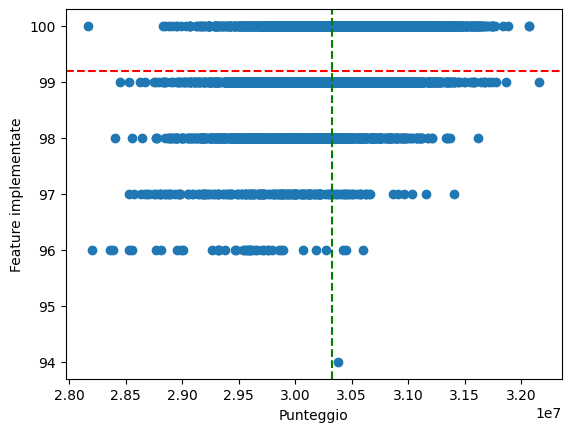

In [14]:
# importing the required module 
import matplotlib.pyplot as plt 
import numpy as np

scores: List[int] = []
completed: List[int] = []
with open("out") as f:
    lines = f.readlines()

for line in lines:
   score, cf =  [int(k) for k in line.split(" ")]
   scores.append(score)
   completed.append(cf)

plt.figure()
plt.axhline(y=np.nanmean(completed), color="red", linestyle="--", label="avg-features")
plt.axvline(x=np.nanmean(scores), color="green", linestyle="--", label="avg-score")

plt.scatter(scores, completed) 
    
plt.xlabel('Punteggio') 
plt.ylabel('Feature implementate') 
plt.legend()
    
plt.title('5000 iterazioni dell\'approccio randomico') 
    
plt.show() 